In [1]:
# general imports
import datetime
import pandas as pd
import numpy as np
import tensorflow as tf
import opendatasets as od
import matplotlib.pyplot as plt

In [2]:
DATATYPE = "datetime64[ns]"
FORMAT = '%Y-%m-%d %H:%M:%S'
LABELS = ['M_WEATHER','M_RAIN_PERCENTAGE']
WINDOW_SIZE = 30

In [3]:
def clean(df):
    df_new = df.drop(['M_ZONE_START','M_ZONE_FLAG'],axis=1)     # Drop start zones and flags
    df_new = df_new.dropna(subset=['M_WEATHER_FORECAST_SAMPLES_M_WEATHER'])     # Drop NaNs from Forecast
    df_new = df_new.loc[df_new['M_NUM_WEATHER_FORECAST_SAMPLES']!=0]       # Only if forecast sample is different than 0
    df_new = df_new.loc[df_new['M_SESSION_TYPE']!=0]        # Only if session type different than 0
    df_new['M_SESSION_UID'] = df_new['M_SESSION_UID'].astype(int)    # Session ID as int
    df_new['TIMESTAMP'] = df_new['TIMESTAMP'].apply(datetime.datetime.fromtimestamp)    # Timestamp as datetime
    df_new = df_new.loc[df_new['M_TIME_OFFSET']==0.0]       # Offset as 0 
    df_new = df_new[df_new['M_WEATHER_FORECAST_SAMPLES_M_SESSION_TYPE']==df_new['M_SESSION_TYPE']] # Session type equal to forecast session type
    return df_new

In [4]:
dataset_folder = "formulaaihackathon2022"
dataset_file = dataset_folder + "/weather.csv"

chunks = []

for chunk in pd.read_csv(dataset_file, sep = ",", chunksize=10**6, low_memory=False):
    part = clean(chunk)
    chunks.append(part)

In [5]:
FEATURES = ['TIMESTAMP',
            'M_TRACK_TEMPERATURE', 
            'M_FORECAST_ACCURACY', 
            'M_AIR_TEMPERATURE', 
            'M_NUM_WEATHER_FORECAST_SAMPLES', 
            'M_WEATHER_FORECAST_SAMPLES_M_SESSION_TYPE',
            'M_WEATHER_FORECAST_SAMPLES_M_WEATHER',
            'M_WEATHER_FORECAST_SAMPLES_M_TRACK_TEMPERATURE',
            'M_TRACK_TEMPERATURE_CHANGE',
            'M_WEATHER_FORECAST_SAMPLES_M_AIR_TEMPERATURE', 
            'M_AIR_TEMPERATURE_CHANGE', 
            'M_TIME_OFFSET']
FEATURES_TO_DROP = ['M_SESSION_UID', 'M_TRACK_ID',]

In [6]:
df = pd.concat(chunks)
df = df.drop_duplicates()
df = df[FEATURES+LABELS+FEATURES_TO_DROP]
print("After cleaning: ", str(len(df)))

After cleaning:  35651


In [7]:
df.tail()

,TIMESTAMP,M_TRACK_TEMPERATURE,M_FORECAST_ACCURACY,M_AIR_TEMPERATURE,M_NUM_WEATHER_FORECAST_SAMPLES,M_WEATHER_FORECAST_SAMPLES_M_SESSION_TYPE,M_WEATHER_FORECAST_SAMPLES_M_WEATHER,M_WEATHER_FORECAST_SAMPLES_M_TRACK_TEMPERATURE,M_TRACK_TEMPERATURE_CHANGE,M_WEATHER_FORECAST_SAMPLES_M_AIR_TEMPERATURE,M_AIR_TEMPERATURE_CHANGE,M_TIME_OFFSET,M_WEATHER,M_RAIN_PERCENTAGE,M_SESSION_UID,M_TRACK_ID
3571974,2022-01-15 23:14:47,33,0,25,10,8.0,0.0,33.0,2.0,25.0,2.0,0.0,0,4.0,-7583928604876334117,28
3572051,2022-01-15 23:14:48,33,0,25,10,8.0,0.0,33.0,2.0,25.0,2.0,0.0,0,4.0,-7583928604876334117,28
3572128,2022-01-15 23:14:49,33,0,25,10,8.0,0.0,33.0,2.0,25.0,2.0,0.0,0,4.0,-7583928604876334117,28
3572205,2022-01-15 23:14:50,33,0,25,10,8.0,0.0,33.0,2.0,25.0,2.0,0.0,0,4.0,-7583928604876334117,28
3572282,2022-01-15 23:14:51,33,0,25,10,8.0,0.0,33.0,2.0,25.0,2.0,0.0,0,4.0,-7583928604876334117,28


(array([24416.,     0.,     0.,     0.,     0.,  9917.,     0.,     0.,
            0.,  1318.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

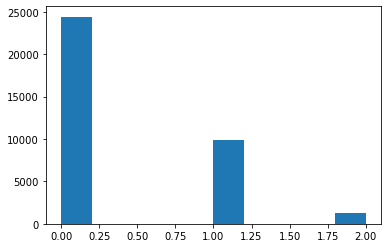

In [8]:
#histogram przed czyszczeniem danych
plt.hist(df['M_WEATHER'])

(array([24416.,     0.,     0.,     0.,     0.,  9917.,     0.,     0.,
            0.,  1318.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

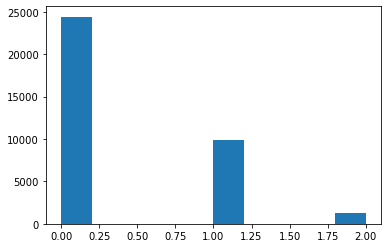

In [9]:
#histogram po czyszczeniu danych + wnioski: Z naszej analizy wynika, że sesje, gdzie M_WEATHER===5 to gry customowe, w któych gracz ustawił const wartrtosc M_WEATHER i to sprawdza ta kolumna: M_NUM_WEATHER_FORECAST_SAMPLES
plt.hist(df['M_WEATHER'])

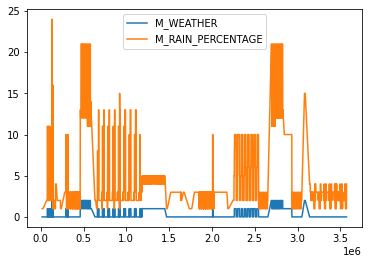

In [10]:
#LSTM - prepare data for models

df_1 = df.drop(['M_SESSION_UID'], axis=1)
df_2 = df.drop(['M_TRACK_ID'], axis=1)
df_3 = df.drop(['M_SESSION_UID', 'M_TRACK_ID'], axis=1)

df_1.index = pd.to_datetime(df_1['TIMESTAMP'], format=FORMAT)
df_2.index = pd.to_datetime(df_2['TIMESTAMP'], format=FORMAT)
df_3.index = pd.to_datetime(df_3['TIMESTAMP'], format=FORMAT)

def split_x_y(df, window_size=WINDOW_SIZE):
    df_X = df[FEATURES].to_numpy()
    df_y = df[LABELS].to_numpy()
    X = []
    y = []
    
    for i in range(len(df_X)-window_size):
        row = [r for r in df_X[i:i+window_size]]
        label = df_y[i+window_size]
        X.append(row)
        y.append(label)
    return np.array(X), np.array(y)

df[LABELS].plot()
X, y = split_x_y(df_3)
# X.shape, y.shape

In [11]:
# tf imports 
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [12]:
# Set configuration

BATCH_SIZE = 64
NUM_EPOCHS = 50
MAX_PATIENCE = 3

In [13]:
# split to train validation
X_train, y_train = X[:25000], y[:25000]
X_val, y_val = X[25000:30000], y[25000:30000] 
X_test, y_test = X[30000:], y[30000:] 

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(25000, 30, 12) (25000, 2)
(5000, 30, 12) (5000, 2)
(5621, 30, 12) (5621, 2)


In [14]:
def generator(samples, labels, batch_size=BATCH_SIZE, shuffle_data=True):
    """ Yields the next training batch."""
    num_samples = len(samples)
    while True: 
        
        X = []
        y = []
        
        for offset in range(0, num_samples, batch_size):
            # Get the samples you'll use in this batch
            batch_samples = samples[offset:offset+batch_size]
            batch_labels = labels[offset:offset+batch_size]
            X_ = []
            y_ = []

            for batch_sample in batch_samples:
                sample = batch_sample
                X_.append(sample)
   
            for batch_label in batch_labels:
                label = batch_label
                y_.append(label)

            X = np.array(X_)
            y = np.array(y_)
            
        yield X, y

In [15]:
model = Sequential()
model.add(InputLayer((12, 2)))
model.add(LSTM(64))
model.add(Dense(32, activation='tanh'))
model.add(Dense(2))
model.summary()

# we will monitor when to stop epochs, it depends on val_loss and it wont stop before 3 epochs no matter what
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=MAX_PATIENCE)
cp1 = ModelCheckpoint('model1/', save_best_only=True)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

2022-02-23 00:17:56.463320: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-02-23 00:17:56.463378: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-02-23 00:17:56.463415: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (e1862a900b82): /proc/driver/nvidia/version does not exist
2022-02-23 00:17:56.463660: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 64)                17152     
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 66        
Total params: 19,298
Trainable params: 19,298
Non-trainable params: 0
_________________________________________________________________
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 64)                17152     
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
________________________________

In [16]:
# Create generator
train_generator = generator(X_train, y_train)
validation_generator = generator(X_val, y_val)
test_generator = generator(X_test, y_test)
num_train_samples = y_train.shape[0]
num_valid_samples = y_val.shape[0]
test_valid_samples = y_test.shape[0]

In [17]:
x,y = next(train_generator)
print (x.shape)

(40, 30, 12)


In [1]:
model.fit(
        train_generator,
        steps_per_epoch=num_train_samples // BATCH_SIZE,
        validation_data=validation_generator,
        validation_steps=num_valid_samples // BATCH_SIZE, 
        epochs=NUM_EPOCHS,
        callbacks=[cp1, early_stop])

In [ ]:
# we make a dataframe from results put in dict, and show it below
train_results = pd.DataFrame(data={'predicted_weather':train_predictions[:,[0,]].flatten(),
                                   'predicted_rain_percentage':train_predictions[:,[1,]].flatten(),
                                   'actual_weather':y_train[:,[0,]].flatten(),
                                   'actual_rain_percentage':y_train[:,[1,]].flatten()
                                  })
train_results

In [ ]:
# makind predictions on X_test data
test_predictions = model1.predict(X_test)

In [ ]:
# we make a dataframe from results put in dict, and show it below
test_results = pd.DataFrame(data={'predicted_weather':test_predictions[:,[0,]].flatten(),
                                   'predicted_rain_percentage':test_predictions[:,[1,]].flatten(),
                                   'actual_weather':y_test[:,[0,]].flatten(),
                                   'actual_rain_percentage':y_test[:,[1,]].flatten()
                                  })
test_results

In [ ]:
# Weather
test_results['predicted_weather'].plot()
test_results['actual_weather'].plot()

In [ ]:
# Rain probability
test_results['predicted_rain_percentage'].plot()
test_results['actual_rain_percentage'].plot()